# Notes

Based on feedback:

* Better not to compute mean values on the three configurations
* Not really meaningful to examine the MAE and validation MAE of the last epoch


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

In [2]:
from ipypublish import nb_setup
# https://stackoverflow.com/a/39566040/11552622
rcparams = {
    'axes.titlesize':13,
    'axes.labelsize':9,
    'xtick.labelsize':8,
    'ytick.labelsize':8
}
plt = nb_setup.setup_matplotlib(rcparams=rcparams)

# Introduction

## Aim

Implement framework to extract data generated by the script `script_stats_dnn.py` and concatenate it. This aims to process data from a single dataset. Further (but easy) manipulation are required to merge everything together (e.g. `pandas.join`).


## Quick implementation overview

The script is runned from a folder containing `X.mat` and `Y.mat` files. It creates a new directory for each tested DNN configuration. For instance, the file hierarchy of the root folder once script is finished: 

```
.
├── 1_hlayers_16_neurons_40_aks
├── 1_hlayers_32_neurons_40_aks
├── 1_hlayers_64_neurons_40_aks
├── 1_hlayers_8_neurons_40_aks
├── 2_hlayers_16_neurons_40_aks
├── 2_hlayers_32_neurons_40_aks
├── 2_hlayers_64_neurons_40_aks
├── 2_hlayers_8_neurons_40_aks
├── 4_hlayers_16_neurons_40_aks
├── 4_hlayers_32_neurons_40_aks
├── 4_hlayers_64_neurons_40_aks
├── 4_hlayers_8_neurons_40_aks
├── 6_hlayers_16_neurons_40_aks
├── 6_hlayers_32_neurons_40_aks
├── 6_hlayers_64_neurons_40_aks
├── 6_hlayers_8_neurons_40_aks
├── X.mat
└── Y.mat
```

Each folder has the structure:

```
1_hlayers_16_neurons_40_aks/
├── coefmaxs.npy
├── coefmins.npy
├── DNN_0D_Model.h5
├── DNN_Performance.eps
├── history.bin
├── log.txt
├── Losses.eps
├── parammaxs.npy
├── parammins.npy
├── Ytestpred.txt
└── Ytest.txt
```

We're interested in the files:

* `history.bin`: a pickled dictionnary containing the keras model's history (losses)
* 

## Setup

In [3]:
path = '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse'

# Prepare code for script 

## Aim

Implement and test some routines that will be subsequently used in a script.

## Walking around file hierarchy

### Aim

Given root folder, obtain the list of all files to load

## Let's go


In [4]:
def get_list(rootdir, fileformat):
    """
    :param fileformat: example: `.txt`
    """
    ls = []
    for dirname, subdirlist, filelist in os.walk(rootdir):
        for file in filelist:
            if file.endswith(fileformat):
                ls.append(os.path.join(dirname, file))
    
    return ls

In [5]:
get_list(path, '.bin')

['/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_16_neurons_100_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_16_neurons_10_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_16_neurons_20_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_16_neurons_40_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_16_neurons_50_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_16_neurons_60_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_32_neurons_100_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_32_neurons_10_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_32_neurons_20_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_32_neurons_40_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_32_neurons_50_aks/history.bin

In [6]:
ls = get_list(path, '.bin')

## Load, extract, create DataFrame

### Aim

Given the list of history files, load them, extract the losses, generate DataFrame.

### Routine: parse dnn config from file path



In [7]:
def parse_config(filepath):
    parent_dir = os.path.basename(os.path.dirname(filepath))
    ls = parent_dir.split('_')
    res = {
        'hlayers': 0,
        'neurons': 2,
        'aks': 4
    }
    return {key: int(ls[index]) for key, index in res.items()}

In [8]:
parse_config(ls[0]), parse_config(ls[1])

({'hlayers': 1, 'neurons': 16, 'aks': 100},
 {'hlayers': 1, 'neurons': 16, 'aks': 10})

### Routine : Extract losses

In [9]:
with open(ls[0], 'rb') as f:
    data = pickle.load(f)
data.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

(0.021853500239943202, 0.02229104356154015)

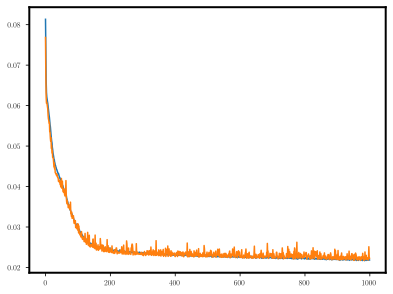

In [10]:
plt.plot(data['loss'])
plt.plot(data['val_loss'])
data['loss'][-1], data['val_loss'][-1]

In [11]:
def load_losses(filepath):
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    # We extract the last item of every list
    return {key: lst[-1] for key, lst in data.items()}

In [12]:
load_losses(ls[0])

{'loss': 0.021853500239943202,
 'mae': 0.09429416,
 'val_loss': 0.02229104356154015,
 'val_mae': 0.0951672}

### Wrapper

In [13]:
def process_stats_data(rootdir):
    files = get_list(rootdir, 'history.bin')
    data = []
    for f in files:
        info = parse_config(f)
        info.update(load_losses(f))
        data.append(info)
    return pd.DataFrame(data).sort_values(['hlayers', 'neurons', 'aks'])

In [14]:
df = process_stats_data(path)
df

hlayers  neurons  aks      loss       mae  val_loss   val_mae
18        1        8   10  0.023051  0.097784  0.022360  0.096270
19        1        8   20  0.021760  0.093726  0.021038  0.091827
20        1        8   40  0.023084  0.095741  0.022269  0.094381
21        1        8   50  0.022321  0.093963  0.021889  0.092850
22        1        8   60  0.061826  0.196905  0.059978  0.192637
..      ...      ...  ...       ...       ...       ...       ...
94        6       64   20  0.003429  0.038268  0.007883  0.052617
95        6       64   40  0.007240  0.054008  0.014531  0.071841
96        6       64   50  0.008186  0.057522  0.019388  0.082023
97        6       64   60  0.008666  0.058180  0.018688  0.081534
92        6       64  100  0.011093  0.066728  0.026902  0.096556

[104 rows x 7 columns]

In [15]:
df.sort_values(['val_loss']).head()

hlayers  neurons  aks      loss       mae  val_loss   val_mae
62        4       64   10  0.003658  0.039269  0.004980  0.046505
35        2       64   10  0.005289  0.048209  0.005864  0.052194
93        6       64   10  0.003799  0.039626  0.005868  0.047915
37        2       64   40  0.006523  0.053136  0.007222  0.055435
31        2       32   20  0.006895  0.054772  0.007237  0.056277

## Plot - Investigate loss <-> architecture

### Aim 

Visualize losses in function of number of layers, number of neurons.

In [16]:
sns.set(style='whitegrid')

In [17]:
def plot_dnn_stats(df):
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    
    ls_hlayers = df['hlayers'].value_counts('hlayers').index.values
    for hlayers in ls_hlayers:
        sub = df[df.hlayers == hlayers]
        ax[0].plot(sub.neurons, sub.val_loss, '-o', label=str(hlayers))
        ax[1].plot(sub.neurons, sub.val_mae, '-o')
    
    ax[0].legend(title='Nb layers')
    ax[0].set_xlabel('Number of neurons')
    ax[0].set_ylabel('Validation loss')
    ax[1].set_xlabel('Number of neurons')
    ax[1].set_ylabel('Mean absolute error')
    plt.subplots_adjust(wspace=.4)
    plt.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


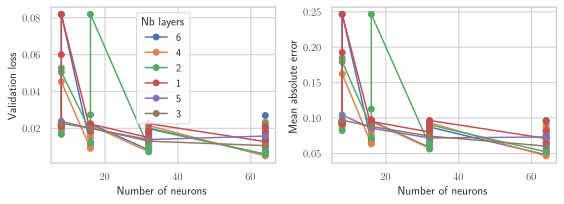

In [18]:
plot_dnn_stats(df)
plt.savefig('figs/dnn_architecture_stats.eps')

## General wrapper

In [19]:
def perform_dnn_architecture_analysis(basefolder, subfolders, suffixes):
    for folder, suffix_name in zip(subfolders, suffixes):
        folderpath = os.path.join(basefolder, folder)
        print(folder)
        
        df = process_stats_data(folderpath)
        plot_dnn_stats(df)
        plt.savefig(f'figs/dnn_architecture_stats_{suffix_name}.eps')

4000RPM_Pulse


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


5000RPM_Pulse


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


6000RPM_Pulse


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


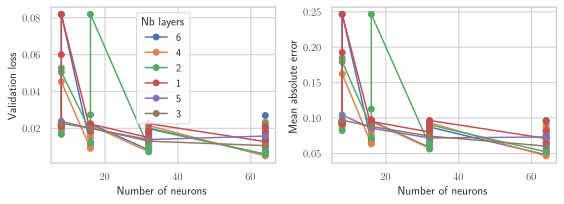

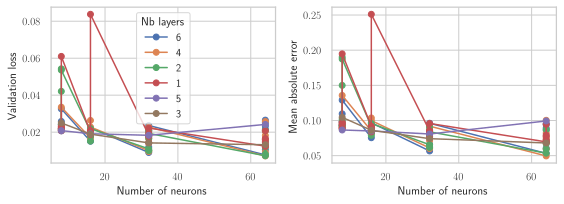

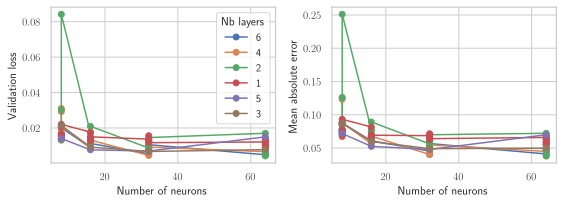

In [20]:
perform_dnn_architecture_analysis('/media/maousi/Data/tmp/dnn_stats', 
                                 ['4000RPM_Pulse', '5000RPM_Pulse', '6000RPM_Pulse'],
                                 ['4000RPM_AP', '5000RPM_AP', '6000RPM_AP'])

In [21]:
!ls $path

1_hlayers_16_neurons_100_aks  4_hlayers_16_neurons_20_aks
1_hlayers_16_neurons_10_aks   4_hlayers_16_neurons_40_aks
1_hlayers_16_neurons_20_aks   4_hlayers_16_neurons_50_aks
1_hlayers_16_neurons_40_aks   4_hlayers_16_neurons_60_aks
1_hlayers_16_neurons_50_aks   4_hlayers_32_neurons_100_aks
1_hlayers_16_neurons_60_aks   4_hlayers_32_neurons_10_aks
1_hlayers_32_neurons_100_aks  4_hlayers_32_neurons_20_aks
1_hlayers_32_neurons_10_aks   4_hlayers_32_neurons_40_aks
1_hlayers_32_neurons_20_aks   4_hlayers_32_neurons_50_aks
1_hlayers_32_neurons_40_aks   4_hlayers_32_neurons_60_aks
1_hlayers_32_neurons_50_aks   4_hlayers_64_neurons_100_aks
1_hlayers_32_neurons_60_aks   4_hlayers_64_neurons_10_aks
1_hlayers_64_neurons_100_aks  4_hlayers_64_neurons_20_aks
1_hlayers_64_neurons_10_aks   4_hlayers_64_neurons_40_aks
1_hlayers_64_neurons_20_aks   4_hlayers_64_neurons_50_aks
1_hlayers_64_neurons_40_aks   4_hlayers_64_neurons_60_aks
1_hlayers_64_neurons_50_aks   4_hlayers_8_neurons_100_aks
1_hlayers_64

In [22]:
tmp = path+'/2_hlayers_32_neurons_40_aks/'

In [23]:
!ls $tmp

coefmaxs.npy	 DNN_Performance.eps  Losses.eps     parammins.npy
coefmins.npy	 history.bin	      Losses.svg     Ytestpred.txt
DNN_0D_Model.h5  log.txt	      parammaxs.npy  Ytest.txt


# Aggregate and analyze results

## Aim

Combines `results.csv` files of all datasets and plot.

## Prerequisites

Run the script `script_stats_dnn.py --analyze` in each folder that is dedicated to a dataset.

## Setup

In [24]:
path = '/media/maousi/Data/tmp/dnn_stats/'
!ls $path

4000RPM_Pulse  5000RPM_Pulse  6000RPM_Pulse  REAMDE.txt


## Combine in a single dataframe

In [25]:
folders = {e : os.path.join(path, e) for e in os.listdir(path)}
folders = filter(lambda e: os.path.isdir(e[1]), folders.items())
folders = dict(folders)
folders

{'4000RPM_Pulse': '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse',
 '5000RPM_Pulse': '/media/maousi/Data/tmp/dnn_stats/5000RPM_Pulse',
 '6000RPM_Pulse': '/media/maousi/Data/tmp/dnn_stats/6000RPM_Pulse'}

In [26]:
# Keys = RPM, value = results file path
files = {int(name.split('RPM')[0]) : os.path.join(path, 'results.csv')
         for name, path in folders.items()}
files

{4000: '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/results.csv',
 5000: '/media/maousi/Data/tmp/dnn_stats/5000RPM_Pulse/results.csv',
 6000: '/media/maousi/Data/tmp/dnn_stats/6000RPM_Pulse/results.csv'}

In [27]:
df = []
for rpm, file in files.items():
    tmp = pd.read_csv(file)
    tmp['RPM'] = rpm
    df.append(tmp)
df = pd.concat(df, ignore_index=True)

In [28]:
df

hlayers  neurons  aks      loss       mae  val_loss   val_mae   RPM
0          1        8   10  0.023051  0.097784  0.022360  0.096270  4000
1          1        8   20  0.021760  0.093726  0.021038  0.091827  4000
2          1        8   40  0.023084  0.095741  0.022269  0.094381  4000
3          1        8   50  0.022321  0.093963  0.021889  0.092850  4000
4          1        8   60  0.061826  0.196905  0.059978  0.192637  4000
..       ...      ...  ...       ...       ...       ...       ...   ...
307        6       64   20  0.004578  0.040315  0.005542  0.046204  6000
308        6       64   40  0.004384  0.039444  0.006831  0.047704  6000
309        6       64   50  0.006941  0.049397  0.007911  0.049528  6000
310        6       64   60  0.007944  0.052158  0.010854  0.057522  6000
311        6       64  100  0.009835  0.058249  0.013437  0.065619  6000

[312 rows x 8 columns]

In [29]:
df.to_csv('data/dnn_stats.csv', index=False)

## Plot

In [30]:
df.head()

hlayers  neurons  aks      loss       mae  val_loss   val_mae   RPM
0        1        8   10  0.023051  0.097784  0.022360  0.096270  4000
1        1        8   20  0.021760  0.093726  0.021038  0.091827  4000
2        1        8   40  0.023084  0.095741  0.022269  0.094381  4000
3        1        8   50  0.022321  0.093963  0.021889  0.092850  4000
4        1        8   60  0.061826  0.196905  0.059978  0.192637  4000

In [31]:
df.neurons.unique()

array([ 8, 16, 32, 64])

     hlayers  neurons  aks      loss       mae  val loss   val_mae   RPM
70         4       64   10  0.003658  0.039269  0.004980  0.046505  4000
42         2       64   10  0.005289  0.048209  0.005864  0.052194  4000
18         1       64   10  0.012962  0.072829  0.012743  0.071144  4000
98         6       64   10  0.003799  0.039626  0.005868  0.047915  4000
71         4       64   20  0.005251  0.045678  0.010125  0.060499  4000
43         2       64   20  0.005405  0.048748  0.007392  0.054261  4000
99         6       64   20  0.003429  0.038268  0.007883  0.052617  4000
19         1       64   20  0.008218  0.058395  0.010814  0.065408  4000
72         4       64   40  0.006488  0.051275  0.013493  0.070423  4000
44         2       64   40  0.006523  0.053136  0.007222  0.055435  4000
100        6       64   40  0.007240  0.054008  0.014531  0.071841  4000
20         1       64   40  0.010569  0.064735  0.014129  0.073951  4000
101        6       64   50  0.008186  0.057522  0.0

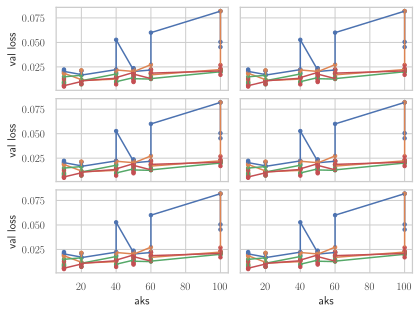

In [32]:
def plot_dataset1(df):
    # Hue = neurons
    # x = number of coeffs
    # y = loss
    # separate plots = hlayers
    
    hue_var, plots = 'neurons', 'hlayers'
    hue_values = df[hue_var].unique()
    n_hue = len(hue_values)
    hlayers_values = df.hlayers.unique()
    n_plots = len(hlayers_values)
    ncol = 2
    x, y = 'aks', 'val loss'
    colors = sns.color_palette()[:n_hue]
    
    df = df.rename({'val_loss' : 'val loss'}, axis=1).sort_values(x)
    
    fig, ax = plt.subplots(int(n_plots/ncol), ncol, sharex=True, sharey=True)
    
    for a, hlayers in zip(ax.ravel(), hlayers_values):
        for i, hueval in enumerate(hue_values):
            sub = df[df[hue_var] == hueval]
            a.plot(sub[x], sub[y], color=colors[i])
            a.scatter(sub[x], sub[y], s=12)
    print(sub)
    # x axis
    for a in ax[-1]: a.set_xlabel(x)
    #for a in ax[:-1].ravel(): a.set_xticks([])
    # y axis
    for a in ax[:, 0]: a.set_ylabel(y)
    #for a in ax[:, 1:].ravel(): a.set_yticks([])
    
    plt.subplots_adjust(wspace=.07, hspace=.1)

plot_dataset1(df[df.RPM == 4000])

## Once again

In [33]:
def plot_dnn_stats(df):
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    
    ls_hlayers = df['hlayers'].unique()
    colors = sns.color_palette()
    for i, hlayers in enumerate(ls_hlayers):
        sub = df[df.hlayers == hlayers]
        ax[0].plot(sub.neurons, sub.val_loss, '-o', label=str(hlayers), color=colors[i])
        #ax[0].plot(sub.neurons, sub.loss, '--o', color=colors[i])
        ax[1].plot(sub.neurons, sub.val_loss - sub.loss, '-o', color=colors[i])
    
    ax[0].legend(title='Nb layers')
    ax[0].set_xlabel('Number of neurons')
    ax[0].set_ylabel('Validation loss')
    ax[1].set_xlabel('Number of neurons')
    ax[1].set_ylabel('Validation loss - training loss')
    plt.subplots_adjust(wspace=.4)
    plt.tight_layout()
    ax[0].grid(ls='--'); ax[1].grid(ls='--')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


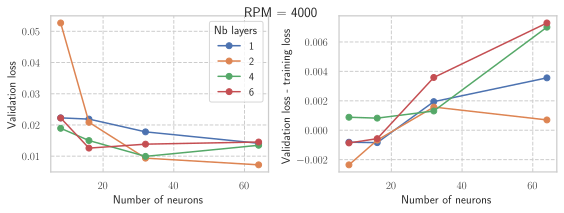

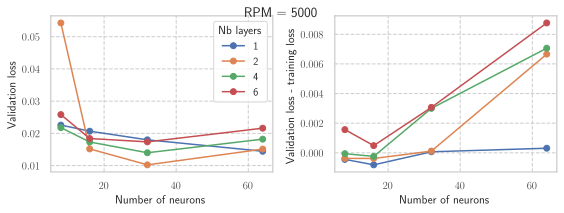

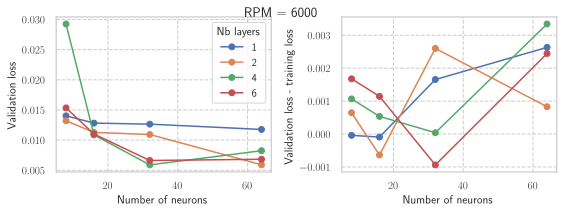

In [34]:
plot_dnn_stats(df[np.logical_and(df.RPM == 4000, df.aks == 40)])
plt.suptitle('RPM = 4000', size=14)
plot_dnn_stats(df[np.logical_and(df.RPM == 5000, df.aks == 40)])
plt.suptitle('RPM = 5000', size=14)
plot_dnn_stats(df[np.logical_and(df.RPM == 6000, df.aks == 40)])
plt.suptitle('RPM = 6000', size=14)
plt.savefig('figs/test.eps')

# Average over 3 datasets



In [35]:
df.shape

(312, 8)

In [36]:
df.head()

hlayers  neurons  aks      loss       mae  val_loss   val_mae   RPM
0        1        8   10  0.023051  0.097784  0.022360  0.096270  4000
1        1        8   20  0.021760  0.093726  0.021038  0.091827  4000
2        1        8   40  0.023084  0.095741  0.022269  0.094381  4000
3        1        8   50  0.022321  0.093963  0.021889  0.092850  4000
4        1        8   60  0.061826  0.196905  0.059978  0.192637  4000

In [37]:
avg = df.groupby(['hlayers', 'neurons', 'aks']).mean().drop('RPM', axis=1)
avg

loss       mae  val_loss   val_mae
hlayers neurons aks                                        
1       8       10   0.020345  0.089752  0.020028  0.089065
                20   0.019610  0.086255  0.019378  0.085565
                40   0.020054  0.086606  0.019621  0.086072
                50   0.022311  0.091928  0.022116  0.092018
                60   0.032435  0.119436  0.033997  0.123394
...                       ...       ...       ...       ...
6       64      20   0.004754  0.042383  0.007983  0.053177
                40   0.008156  0.054468  0.014324  0.068556
                50   0.009593  0.059480  0.016877  0.073616
                60   0.010231  0.061014  0.018209  0.077798
                100  0.011816  0.066621  0.022288  0.085968

[104 rows x 4 columns]

In [38]:
avg = avg.reset_index().sort_values(['hlayers', 'neurons'])
avg

hlayers  neurons  aks      loss       mae  val_loss   val_mae
0          1        8   10  0.020345  0.089752  0.020028  0.089065
1          1        8   20  0.019610  0.086255  0.019378  0.085565
2          1        8   40  0.020054  0.086606  0.019621  0.086072
3          1        8   50  0.022311  0.091928  0.022116  0.092018
4          1        8   60  0.032435  0.119436  0.033997  0.123394
..       ...      ...  ...       ...       ...       ...       ...
99         6       64   20  0.004754  0.042383  0.007983  0.053177
100        6       64   40  0.008156  0.054468  0.014324  0.068556
101        6       64   50  0.009593  0.059480  0.016877  0.073616
102        6       64   60  0.010231  0.061014  0.018209  0.077798
103        6       64  100  0.011816  0.066621  0.022288  0.085968

[104 rows x 7 columns]

In [39]:
avg.to_csv('data/dnn_stats_avg.csv', index=False)

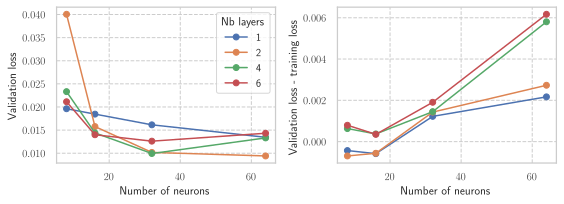

In [40]:
plot_dnn_stats(avg[avg.aks == 40])

# Best configurations

In [41]:
avg[avg.aks == 50].sort_values('val_mae')

hlayers  neurons  aks      loss       mae  val_loss   val_mae
45         2       64   50  0.007677  0.054280  0.008846  0.058834
51         3       64   50  0.007759  0.053934  0.010532  0.059400
73         4       64   50  0.007305  0.051633  0.012596  0.064372
67         4       32   50  0.010294  0.062624  0.012229  0.065809
50         3       32   50  0.010618  0.063666  0.011313  0.065913
78         5       32   50  0.011445  0.064776  0.013060  0.066839
21         1       64   50  0.011806  0.066666  0.014426  0.072188
39         2       32   50  0.010642  0.064050  0.014030  0.072371
95         6       32   50  0.011981  0.066575  0.014776  0.072872
101        6       64   50  0.009593  0.059480  0.016877  0.073616
77         5       16   50  0.015742  0.076669  0.015591  0.074430
15         1       32   50  0.015789  0.077337  0.016310  0.077062
49         3       16   50  0.015521  0.076483  0.016083  0.077941
89         6       16   50  0.016792  0.079643  0.016437  0.079518
33         2       16   50  0.016618  0.079102  0.016444  0.080353
79         5       64   50  0.007636  0.052779  0.018321  0.080858
9          1       16   50  0.018449  0.082600  0.018098  0.081965
55         4        8   50  0.018654  0.085154  0.018940  0.085649
61         4       16   50  0.013495  0.072828  0.018717  0.086798
76         5        8   50  0.019542  0.087273  0.019551  0.087470
3          1        8   50  0.022311  0.091928  0.022116  0.092018
83         6        8   50  0.022512  0.095566  0.022046  0.092254
48         3        8   50  0.022179  0.094159  0.022963  0.096389
27         2        8   50  0.031934  0.123937  0.031655  0.124147

In [42]:
avg[avg.aks == 40].sort_values('val_loss')

hlayers  neurons  aks      loss       mae  val_loss   val_mae
44         2       64   40  0.006686  0.050863  0.009416  0.056814
66         4       32   40  0.008492  0.057063  0.009942  0.059743
38         2       32   40  0.008747  0.058632  0.010177  0.063378
94         6       32   40  0.010707  0.063541  0.012612  0.065407
72         4       64   40  0.007513  0.052207  0.013316  0.065195
20         1       64   40  0.011281  0.064864  0.013449  0.069889
88         6       16   40  0.013646  0.072192  0.013998  0.072586
100        6       64   40  0.008156  0.054468  0.014324  0.068556
60         4       16   40  0.014024  0.073234  0.014396  0.074782
32         2       16   40  0.016332  0.078752  0.015769  0.077001
14         1       32   40  0.014920  0.074686  0.016144  0.078318
8          1       16   40  0.019038  0.083821  0.018456  0.082348
2          1        8   40  0.020054  0.086606  0.019621  0.086072
82         6        8   40  0.020339  0.090554  0.021132  0.093470
54         4        8   40  0.022688  0.098430  0.023320  0.103592
26         2        8   40  0.040741  0.149493  0.040047  0.148466

In [43]:
avgtmp = avg[avg.aks == 40].sort_values('val_loss')
print(avgtmp.to_latex(index=False, escape=True))

\begin{tabular}{rrrrrrr}
\toprule
 hlayers &  neurons &  aks &      loss &       mae &  val\_loss &   val\_mae \\
\midrule
       2 &       64 &   40 &  0.006686 &  0.050863 &  0.009416 &  0.056814 \\
       4 &       32 &   40 &  0.008492 &  0.057063 &  0.009942 &  0.059743 \\
       2 &       32 &   40 &  0.008747 &  0.058632 &  0.010177 &  0.063378 \\
       6 &       32 &   40 &  0.010707 &  0.063541 &  0.012612 &  0.065407 \\
       4 &       64 &   40 &  0.007513 &  0.052207 &  0.013316 &  0.065195 \\
       1 &       64 &   40 &  0.011281 &  0.064864 &  0.013449 &  0.069889 \\
       6 &       16 &   40 &  0.013646 &  0.072192 &  0.013998 &  0.072586 \\
       6 &       64 &   40 &  0.008156 &  0.054468 &  0.014324 &  0.068556 \\
       4 &       16 &   40 &  0.014024 &  0.073234 &  0.014396 &  0.074782 \\
       2 &       16 &   40 &  0.016332 &  0.078752 &  0.015769 &  0.077001 \\
       1 &       32 &   40 &  0.014920 &  0.074686 &  0.016144 &  0.078318 \\
       1 &       16

# Plot effect of number of coefficients



# Overfitting evaluation



In [44]:
def parse_config(filepath):
    parent_dir = os.path.basename(os.path.dirname(filepath))
    ls = parent_dir.split('_')
    
    # values are indexes of element in `ls`
    res = {
        'hlayers': 0,
        'neurons': 2,
        'aks': 4
    }
    # Fill in with corresponding values
    res = {key: int(ls[index]) for key, index in res.items()}
    
    # Get RPM
    parent_parent_dir = os.path.dirname(os.path.dirname(filepath))
    parent_parent_dir = os.path.basename(parent_parent_dir)
    rpm = int(parent_parent_dir.split('RPM')[0])
    res['RPM'] = rpm
    
    return res

In [45]:
files = get_list(path, 'history.bin')

In [46]:
parse_config(files[0]), files[0]

({'hlayers': 1, 'neurons': 16, 'aks': 100, 'RPM': 4000},
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_16_neurons_100_aks/history.bin')

In [47]:
parse_config(files[-1]), files[-1]

({'hlayers': 6, 'neurons': 8, 'aks': 60, 'RPM': 6000},
 '/media/maousi/Data/tmp/dnn_stats/6000RPM_Pulse/6_hlayers_8_neurons_60_aks/history.bin')

In [48]:
# Load data
# File structure: dictionnary
# key = (RPM, layers, neurons, aks)
# value = dictionnary {'loss': [...], 'val_loss': [...], ...}
data = {}

for f in files:
    conf = parse_config(f)
    key = (conf['RPM'], conf['hlayers'], conf['neurons'], conf['aks'])
    
    # Open the 'history' binary file containing losses and mae
    with open(f, 'rb') as file:
        data[key] = pickle.load(file)
    print('.', end='')

........................................................................................................................................................................................................................................................................................................................

In [49]:
len(data), len(files)

(312, 312)

In [50]:
with open('data/dnn_stats_data.bin', 'wb') as f:
    pickle.dump(data, f)

## Plot

Idea: plot losses and validation losses of all three data sets for a given DNN architecture and input size. Compute and display mean loss, validation loss, mae and validation mae.

In [51]:
def plot_statistics(data, configs, rpms, display_values, fun_descr):
    nrow = len(configs)
    ncol = len(rpms)
    fig, axgrid = plt.subplots(nrow, ncol, figsize=(2.8*ncol + .5, 1.75*nrow + .5),
                              sharey='row', sharex='col')
    
    for i, (axes, config) in enumerate(zip(axgrid, configs)):
        # Plot data
        last_val = {val: [] for val in display_values}
        for rpm, a in zip(rpms, axes):
            key = (rpm, ) + config
            a.plot(data[key]['loss'], label='loss', lw=.5)
            a.plot(data[key]['val_loss'], label='val loss', lw=.5)
            # Extract last values
            for val in display_values:
                last_val[val].append(data[key][val][-1])
            #last_val['loss'].append(data[key]['loss'])
        
        
        
        # X-Label management
        # First row vs not
        if i == 0:
            axes[0].legend()
            for rpm, a in zip(rpms, axes): a.set_title(f'{rpm} RPM')
        # Last row vs not
        #if i < nrow-1:
        #    for a in axes: a.set_xticklabels([])
        #else:
        #    for a in axes: a.set_xlabel('Epochs')
        
        # Y-label management
        axes[0].set_ylabel('Loss')
        #axes[-1].yaxis.set_label_position('right')
        #axes[-1].yaxis.tick_right()
        
        #fig.align_ylabels(axes)
        
        # Text management - Compute mean values, display
        text = '\n'.join([
            'mean ' + val.replace("_", " ") + ': ' + \
            '{:.3}'.format(np.mean(last_val[val]))
            for val in display_values
        ])
        text = '\\textbf{'+fun_descr(config)+'}' + '\n' + text
        axes[0].text(-1.5, .5, text, transform=axes[0].transAxes, 
                     verticalalignment='center')
    
    for a in axgrid[-1]: a.set_xlabel('Epochs')
    # General plot properties
    fig.subplots_adjust(wspace=.05, hspace=.05)
    plt.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


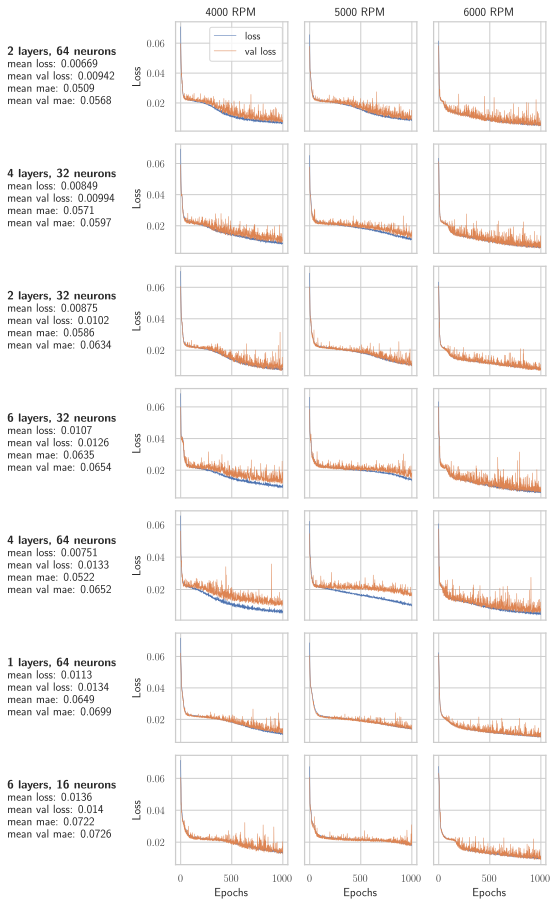

In [52]:
configs = [(2, 64, 40),
           (4, 32, 40),
           (2, 32, 40),
           (6, 32, 40),
           (4, 64, 40),
           (1, 64, 40),
           (6, 16, 40)]
fun_descr = lambda config: f'{config[0]} layers, {config[1]} neurons'
plot_statistics(data, configs, [4000, 5000, 6000], 
                ['loss', 'val_loss', 'mae', 'val_mae'], fun_descr)
plt.savefig('figs/dnn_statistics_sorted_40aks.eps', bbox_inches='tight')

# Sort by validation loss

In [53]:
best = avg.sort_values('val_loss').reset_index(drop=True)
best.head(10)

hlayers  neurons  aks      loss       mae  val_loss   val_mae
0        6       64   10  0.004314  0.040691  0.006157  0.047402
1        4       64   10  0.004665  0.041639  0.006251  0.047016
2        2       64   20  0.005978  0.048215  0.006586  0.050578
3        4       32   10  0.006469  0.050418  0.007268  0.052857
4        6       32   10  0.006307  0.049436  0.007553  0.053523
5        6       64   20  0.004754  0.042383  0.007983  0.053177
6        4       64   20  0.005013  0.042955  0.008066  0.052692
7        2       32   20  0.008278  0.057318  0.008620  0.057222
8        2       64   50  0.007677  0.054280  0.008846  0.058834
9        6       32   20  0.007523  0.052955  0.009249  0.056529

In [54]:
def df2config(df):
    return [
        (l, n, c) for l,n,c in zip(df.hlayers, df.neurons, df.aks)
    ]

In [55]:
df2config(best.head(10))

[(6, 64, 10),
 (4, 64, 10),
 (2, 64, 20),
 (4, 32, 10),
 (6, 32, 10),
 (6, 64, 20),
 (4, 64, 20),
 (2, 32, 20),
 (2, 64, 50),
 (6, 32, 20)]

In [56]:
best[best.aks == 40]

hlayers  neurons  aks      loss       mae  val_loss   val_mae
10        2       64   40  0.006686  0.050863  0.009416  0.056814
13        4       32   40  0.008492  0.057063  0.009942  0.059743
15        2       32   40  0.008747  0.058632  0.010177  0.063378
25        6       32   40  0.010707  0.063541  0.012612  0.065407
27        4       64   40  0.007513  0.052207  0.013316  0.065195
28        1       64   40  0.011281  0.064864  0.013449  0.069889
30        6       16   40  0.013646  0.072192  0.013998  0.072586
35        6       64   40  0.008156  0.054468  0.014324  0.068556
36        4       16   40  0.014024  0.073234  0.014396  0.074782
47        2       16   40  0.016332  0.078752  0.015769  0.077001
50        1       32   40  0.014920  0.074686  0.016144  0.078318
65        1       16   40  0.019038  0.083821  0.018456  0.082348
79        1        8   40  0.020054  0.086606  0.019621  0.086072
88        6        8   40  0.020339  0.090554  0.021132  0.093470
94        4        8   40  0.022688  0.098430  0.023320  0.103592
98        2        8   40  0.040741  0.149493  0.040047  0.148466

# Conmpare effect of aks


## For the assumed best architecture



In [57]:
a = df2config(best.head(1))[0]
a

(6, 64, 10)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


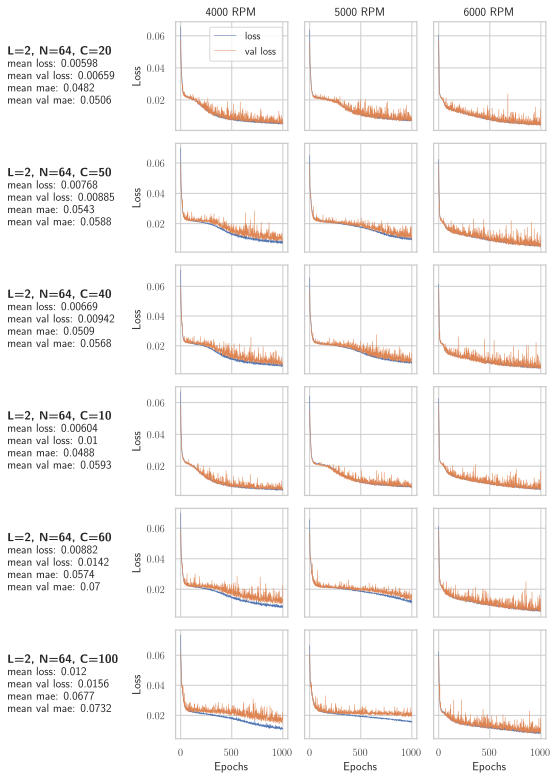

In [58]:
sub = avg[np.logical_and(avg.hlayers == 2, avg.neurons == 64)].sort_values('val_loss')
configs = df2config(sub)
fun_descr = lambda config: f'L={config[0]}, N={config[1]}, C={config[2]}'
plot_statistics(data, configs, [4000, 5000, 6000], 
                ['loss', 'val_loss', 'mae', 'val_mae'], fun_descr)
plt.savefig('figs/dnn_statistics_2layers_64neurons.eps', bbox_inches='tight')

## Sort irrespectively of the number of coefs



In [59]:
best.head(10)

hlayers  neurons  aks      loss       mae  val_loss   val_mae
0        6       64   10  0.004314  0.040691  0.006157  0.047402
1        4       64   10  0.004665  0.041639  0.006251  0.047016
2        2       64   20  0.005978  0.048215  0.006586  0.050578
3        4       32   10  0.006469  0.050418  0.007268  0.052857
4        6       32   10  0.006307  0.049436  0.007553  0.053523
5        6       64   20  0.004754  0.042383  0.007983  0.053177
6        4       64   20  0.005013  0.042955  0.008066  0.052692
7        2       32   20  0.008278  0.057318  0.008620  0.057222
8        2       64   50  0.007677  0.054280  0.008846  0.058834
9        6       32   20  0.007523  0.052955  0.009249  0.056529

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


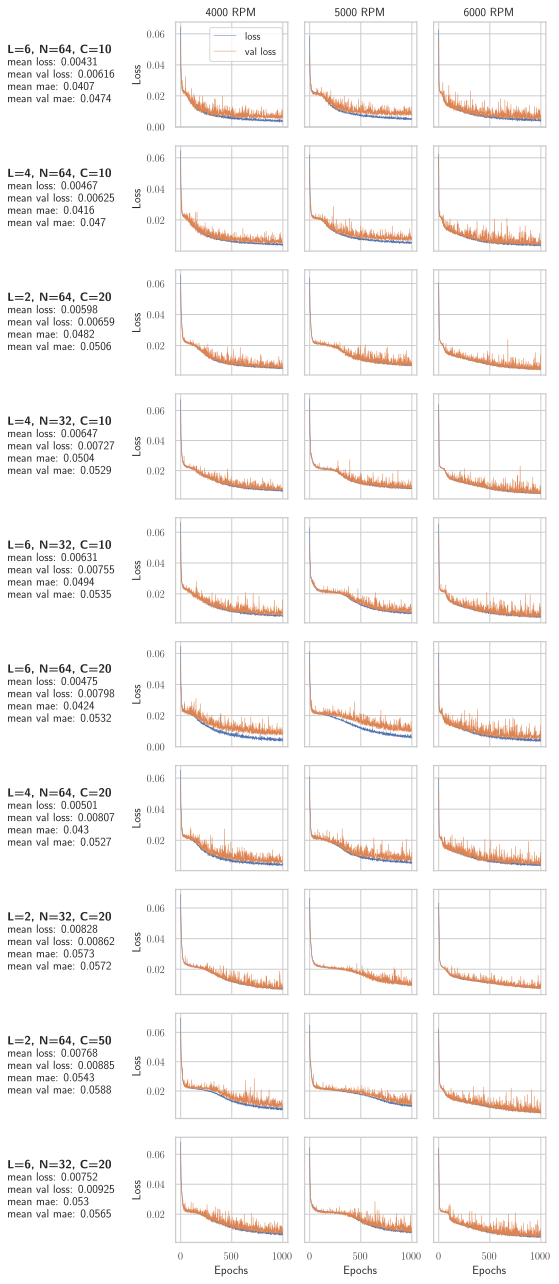

In [60]:
configs = df2config(best.head(10))
fun_descr = lambda config: f'L={config[0]}, N={config[1]}, C={config[2]}'
plot_statistics(data, configs, [4000, 5000, 6000], 
                ['loss', 'val_loss', 'mae', 'val_mae'], fun_descr)
plt.savefig('figs/dnn_statistics_best.eps', bbox_inches='tight')